# COVID-19 and Temperature

As we approach the summer months, how might the rate of COVID-19 infections in humans increase or decrease? I aim to find a correlation between the infection rate and the temperature. To accomplish this, I will gather data about various US counties' daily:

- Total number of infections
- Total number of deaths
- Average temperature
- Infection Rate

I wanted to drill in the data down to the county and month in order to leave out rooms for error such as the different temperatures per month and the varied temperatures between counties. This level of specificity should be fairly sufficient since counties generally have the same temperature due to small variations in latitude, longitude, and biomes between them. I also elected to choose the United States only because of the varied temperatures and biomes it has, and also the US had widespread testing insufficiencies. If I included other countries, that would skew the data.

### Datasets

I chose 66 counties out of the BigQuery Public Data COVID-19 USAFacts dataset and obtained the daily deaths, population and weather data of each county.

USAFacts Google COVID Infections Dataset: https://console.cloud.google.com/marketplace/details/bigquery-public-datasets/covid19-dataset-list?filter=solution-type:dataset&filter=category:covid19&id=4a850823-3f83-48f5-92d1-01ba6f8ed81e

```SELECT * FROM `bigquery-public-data.covid19_usafacts.confirmed_cases```

```SELECT * FROM `bigquery-public-data.covid19_usafacts.deaths```

Wunderground weather: https://www.wunderground.com/history

Populations: https://api.census.gov/data/2019/pep/population?get=POP&for=county:*&in=state:*&key=<KEY>


In [153]:
import pandas
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff


In [154]:
# Clean up infections data

def clean_infections():
    covid_data = pandas.read_csv('./data-sources/confirmed-usafacts.csv')

    # Remove FIPS Code & January
    covid_data.drop(covid_data.columns[3:14], axis=1, inplace=True)

    # Remove May
    covid_data.drop(covid_data.columns[93:], axis=1, inplace=True)

    # Remove unneeded cities
    covid_data.drop(covid_data.index[108:], inplace=True)

    # Counties with no temperature data - remove
    drop = [13,18,21,26,32,33,35,36,37,38,39,42,43,44,45,46,47,50,58,59,60,61,62,66,69,70,71,73,74,78,82,84,85,86,87,88,89,93,94,97,98,106]

    for i in reversed(range(len(drop))):
        covid_data.drop(covid_data.index[drop[i]], inplace=True)

    # Save
    covid_data.to_csv('./covid-clean.csv')

In [155]:
# Clean up deaths data

def clean_deaths():
    deaths_data = pandas.read_csv('./covid-clean-deaths.csv')

    # Remove FIPS Code & January
    deaths_data.drop(deaths_data.columns[4:15], axis=1, inplace=True)

    # Remove May
    deaths_data.drop(deaths_data.columns[94:], axis=1, inplace=True)

    # Save
    deaths_data.to_csv('./covid-clean-deaths.csv', index=False)

In [156]:
# Remove Feb 29

def clean_temperature():
    temperature = pandas.read_csv('./covid-temperature.csv')

    temperature.drop(temperature.columns[32], axis=1, inplace=True)

    temperature.to_csv('./covid-temperature.csv', index=False)

In [157]:
# Sort deaths to match indices of infections

def match_dataset_indices():
    covid_data = pandas.read_csv('./covid-clean.csv')
    deaths_data = pandas.read_csv('./covid-clean-deaths.csv')
    d_data = pandas.read_csv('./covid-cleaner-deaths.csv')

    deaths = []

    for i in range(0, len(covid_data) - 1):
        for j in range(0, len(deaths_data) - 1):
            if covid_data.values[i][1] == deaths_data.values[j][0]:
                deaths.append(deaths_data.values[j])

    for i in deaths:
        d_data.loc[len(d_data)] = i

    d_data.to_csv('./covid-cleaner-deaths.csv')


In [158]:
# Accumulate infections for each temperature (old idea)

infections = pandas.read_csv('./covid-clean.csv')
temperature = pandas.read_csv('./covid-temperature.csv')

temp_infections = {}

for i in range(0,65):
    for j in range(4,93):
        temp_infections[float(temperature.values[i][j])] = temp_infections.get(float(temperature.values[i][j]), 0) + float(infections.values[i][j])

In [159]:
# Accumulate # infections for each temperature & store (old idea)

import math

# Store values

df = pandas.DataFrame([[items[0], items[1]] for items in temp_infections.items() if not math.isnan(items[0])], columns=['temperature', 'infections'])

df.to_csv('temp-vs-infections.csv', index=False)

In [160]:
# Get populations data

def get_population_data():
    cc = pandas.read_csv('./covid-clean.csv')

    p = []

    for i in range(0, len(cc.values)):
        for j in range(0, len(populations)):
            if (str(cc.values[i][1]) == str(int(populations[j][1] + populations[j][2]))):
                p.append([cc.values[i][1], cc.values[i][2], populations[j][0]])

def write_population_data():
    pop = pandas.read_csv('./covid-populations.csv')

    for i in p:
        pop.loc[len(pop)] = i

    pop.to_csv('./covid-populations.csv')


In [161]:
# For SQL query

def sql_query():
    cc = pandas.read_csv('./covid-clean.csv')

    v = cc.values[:,1:2]
    s = "' OR county_fips_code='"

    print(s.join(['0' + str(i[0]) if len(str(i[0])) == 4 else str(i[0]) for i in v]))

In [162]:
infected = pandas.read_csv('./covid-clean.csv')
population = pandas.read_csv('./covid-populations.csv')
dead = pandas.read_csv('./covid-clean-deaths.csv')

In [163]:
# Calculate infection rate for each county
days = 90 # days

beta = []

for i in range(0, len(infected.values)):
    I = 0 # Infected
    R = 0 # Recovered

    # Accumulate recovered and infected
    for j in range(4,94):
        I = I + int(infected.values[i][j])
        R = R + int(dead.values[i][j])

    S = int(population.values[i][3]) - I - R # Suseptible

    # Store infection rate according to county
    beta.append([infected.values[i][1], infected.values[i][2], infected.values[i][3], population.values[i][3], -((S + I + R) / (I * S)) * -((S) / days)])
    

[[6073, 'San Diego County', 'CA', 3338330, 0.5443739991716158], [1097, 'Mobile County', 'AL', 413210, 0.27591479700854704], [34015, 'Gloucester County', 'NJ', 291636, 0.1649310327276429], [26065, 'Ingham County', 'MI', 292406, 0.36374334477782755], [29077, 'Greene County', 'MO', 293086, 1.2720746527777778], [42007, 'Beaver County', 'PA', 163929, 0.27266966067864273], [55133, 'Waukesha County', 'WI', 404198, 0.5900011677468325], [6097, 'Sonoma County', 'CA', 494336, 1.001754919245344], [13057, 'Cherokee County', 'GA', 258773, 0.3503845424756952], [25027, 'Worcester County', 'MA', 830622, 0.11208974499111375], [42089, 'Monroe County', 'PA', 170271, 0.07323011418618154], [48201, 'Harris County', 'TX', 4713325, 0.45878071832728384], [16083, 'Twin Falls County', 'ID', 86878, 0.3215559997039011], [21059, 'Daviess County', 'KY', 101511, 0.36442649434571894], [25011, 'Franklin County', 'MA', 70180, 0.15073995317567712], [48309, 'McLennan County', 'TX', 256623, 1.1860926234054352], [48321, 'Mat

In [164]:
# store infection rates

def write_infection_rate():
    infection_rate = pandas.read_csv('./covid-infection-rate.csv')

    for i in beta:
        infection_rate.loc[len(infection_rate)] = i

    infection_rate.to_csv('./covid-infection-rate.csv')


In [165]:
# Calculate sample mean and variance for each county

temperature = pandas.read_csv('./covid-temperature.csv')
days = 89 # did not get data for one day

temps = []

# Loop through temperature data
for i in range(0, len(temperature.values)):
    total_temp = 0.0

    # find total temp for county for average
    for j in range(4, 93):
        total_temp = total_temp + float(temperature.values[i][j])

    # Get average
    average = total_temp / days
    
    # Get numerator for variance
    var_num = 0.0
    for j in range(4, 93):
        var_num = (float(temperature.values[i][j]) - average)**2

    # Variance
    variance = var_num / (days - 1)

    # Store variance, average, transmission rate according to county
    temps.append([infected.values[i][1], infected.values[i][2], infected.values[i][3], average, variance, beta[i][4]])
    

[[6073, 'San Diego County', 'CA', 61.462921348314595, 0.3871759907495622, 0.5443739991716158], [1097, 'Mobile County', 'AL', 63.559550561797764, 0.0006569992310428377, 0.27591479700854704], [34015, 'Gloucester County', 'NJ', 47.056179775280896, 2.5038522598156807, 0.1649310327276429], [26065, 'Ingham County', 'MI', 30.737078651685394, 13.890975786459471, 0.36374334477782755], [29077, 'Greene County', 'MO', 45.150561797752836, 0.6649307364772532, 1.2720746527777778], [42007, 'Beaver County', 'PA', 42.71685393258428, 0.9375402554773822, 0.27266966067864273], [55133, 'Waukesha County', 'WI', 37.28876404494383, 0.7476380536204082, 0.5900011677468325], [6097, 'Sonoma County', 'CA', 52.46741573033706, 0.8665685003041442, 1.001754919245344], [13057, 'Cherokee County', 'GA', 59.77191011235953, 0.39934374677210516, 0.3503845424756952], [25027, 'Worcester County', 'MA', 37.91123595505619, 0.3940629770116242, 0.11208974499111375], [42089, 'Monroe County', 'PA', 44.57640449438203, 0.21242588745681

In [166]:
# Store final data

def write_final_data():
    final_data = pandas.read_csv('./covid-final-data.csv')

    for i in temps:
        final_data.loc[len(final_data)] = i

    final_data.to_csv('./covid-final-data.csv')


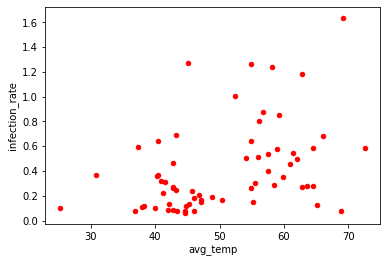

In [167]:
# Plot avg temp vs infection rate

final_data = pandas.read_csv('./covid-final-data.csv')

final_data.plot(kind='scatter',x='avg_temp',y='infection_rate',color='red')
plt.show()

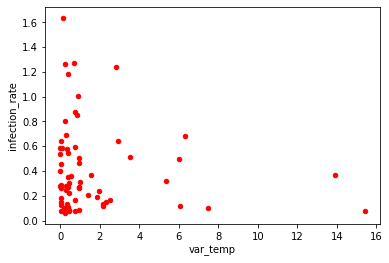

In [168]:
# Plot infection rate vs infection rate

final_data.plot(kind='scatter',x='var_temp',y='infection_rate',color='red')
plt.show()

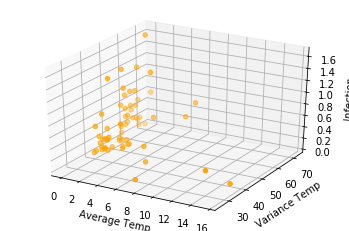

In [169]:
# Avg temp, variance temp, infection rate on 3d plot

threedee = plt.figure().gca(projection='3d')

threedee.scatter(final_data['var_temp'], final_data['avg_temp'], final_data['infection_rate'], marker="o", c='orange')

threedee.set_xlabel('Average Temp')
threedee.set_ylabel('Variance Temp')
threedee.set_zlabel('Infection')

plt.show()

In [177]:
# Data variations

avg_var_infection = final_data.values[:,4:7]
var_infection = final_data.values[:,5:7]
avg_infection = final_data.values[:,[4,6]]
correct_fips = [str(i[0]) if len(i) == 5 else '0' + str(i[0]) for i in final_data.values[:,[1]]]

# Clustering

In this section, I aim to apply clustering to make sense of my data, specifically HBDSCAN, a heirarchical algorithm. It returns the clusters by index (-1,0,1,...) where -1 is non-clustered data and 0,1,... are the clustered data. Additionally, it has a probability score attached to each data point, specifying the strength of the cluster classification. 

I aim to cluster three variation of feature sets:
- Average Temp, Variance of Temp, Infection Rate
- Variance of Temp, Infection Rate
- Average Temp, Infection Rate

## Average Temp, Variance of Temp, Infection Rate

[ 0  0  1 -1  1  1 -1  0  0  1  1  0 -1  0  0  0 -1  1  1  1  0  1  0 -1
 -1  0  0  1  0  1  0  1  1  1  1  0  1  1  0  1  1  1  1  1  0  0  1  1
  0  0  1 -1  0  0  1 -1  0 -1  0  1  0 -1  1  1 -1]
1
[0.93541703 1.         0.45661075 0.         0.49260804 1.
 0.         0.76582962 1.         0.2622182  0.56950931 1.
 0.         1.         1.         1.         0.         0.9223186
 0.67325484 0.55166246 1.         1.         1.         0.
 0.         1.         0.67709766 0.32243047 0.76163569 1.
 1.         0.50811787 0.95742124 0.69507957 0.42467228 1.
 0.56740144 0.56725893 1.         1.         0.23173141 1.
 0.55644231 0.55644231 1.         1.         0.43358276 0.47568504
 1.         1.         0.54275749 0.         1.         1.
 0.2841276  0.         0.60751292 0.         1.         0.47744209
 1.         0.         0.98721048 0.90221954 0.        ]


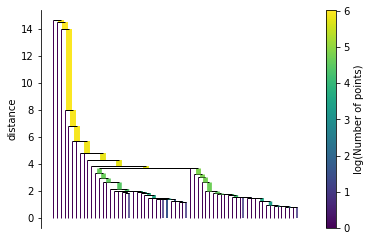

In [178]:
import hdbscan
from sklearn.datasets import make_blobs

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

cluster_labels = clusterer.fit(avg_var_infection)

print(clusterer.labels_)
print(clusterer.labels_.max())
print(clusterer.probabilities_)

clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

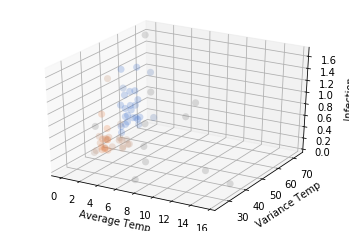

In [179]:
color_palette = sns.color_palette('muted')
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

threedee = plt.figure().gca(projection='3d')

s = threedee.scatter(final_data['var_temp'], final_data['avg_temp'], final_data['infection_rate'], label=cluster_colors, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

threedee.set_xlabel('Average Temp')
threedee.set_ylabel('Variance Temp')
threedee.set_zlabel('Infection')

plt.show()

In [180]:
values_var_avg = [int(i) for i in clusterer.labels_]

fig = ff.create_choropleth(fips=correct_fips, values=values_var_avg, legend_title='Cluster Labels (-1 = unclustered)', show_hover=True, colorscale = ["#8C8C8C","#4878D0","#EE8549"])
# fig.layout.template = None
fig.show()

## Variance of Temp, Infection Rate

[ 2  2 -1 -1 -1  1 -1 -1  2  2  2  2 -1  2 -1  2 -1  2  2 -1  1  2  2  2
 -1  2 -1 -1  2  1  2  2  2  1  2  2 -1  2 -1  1  1  1 -1  0  2 -1  0  0
  2  2  2 -1  2  2  0 -1 -1 -1  2  0 -1  2  2  2 -1]
2
[0.70193231 1.         0.         0.         0.         1.
 0.         0.         1.         1.         0.91074569 0.96182512
 0.         1.         0.         1.         0.         0.70238666
 1.         0.         0.97795834 1.         0.83477988 0.88653981
 0.         0.70238666 0.         0.         1.         1.
 1.         0.74541359 0.84608751 1.         1.         1.
 0.         0.84906393 0.         1.         0.88021469 1.
 0.         1.         1.         0.         1.         1.
 1.         1.         1.         0.         0.67844026 1.
 1.         0.         0.         0.         0.57092847 1.
 0.         0.88755328 1.         0.8680803  0.        ]


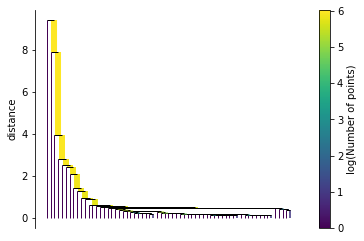

In [181]:
clusterer_var = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

cluster_labels = clusterer_var.fit(var_infection)

print(clusterer_var.labels_)
print(clusterer_var.labels_.max())
print(clusterer_var.probabilities_)

clusterer_var.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

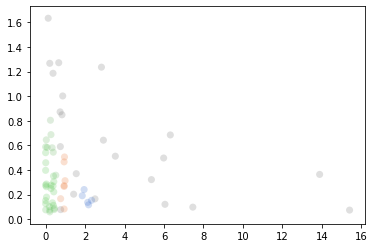

In [182]:
color_palette = sns.color_palette('muted')
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer_var.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer_var.probabilities_)]
plt.scatter(*var_infection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [183]:
values_var = [int(i) for i in clusterer_var.labels_]

fig = ff.create_choropleth(fips=correct_fips, values=values_var, legend_title='Cluster Labels (-1 = unclustered)', colorscale = ["#8C8C8C", "#4878D0", '#EE8549', '#55A868'], show_hover=True)
# fig.layout.template = None
fig.show()

## Avg of Temp, Infection Rate

[ 1  1  0 -1  0  0  0  1  1  0  0  1  0  1  1  1 -1  0  0  0  1  0  1 -1
  0  1  1  0  1  0  1  0  0  0  0  1  0  0  1  0  0  0  0  0  1  1  0  0
  1  1  0 -1  1  1  0  1  1  1  1  0  1 -1  0  0  0]
1
[0.8249121  0.8249121  0.84332506 0.         0.85550379 1.
 0.38477957 0.56402203 0.8249121  0.48543693 1.         0.76029109
 1.         1.         0.74214906 0.79040289 0.         1.
 1.         1.         1.         1.         0.77129578 0.
 0.33264306 1.         1.         1.         0.5869913  1.
 1.         1.         1.         1.         0.91812249 1.
 1.         0.99986857 1.         1.         0.32870794 1.
 1.         1.         1.         0.8611434  0.94146858 0.82857282
 1.         0.79040289 1.         0.         1.         1.
 0.42336362 0.8249121  1.         0.49263622 1.         1.
 1.         0.         1.         1.         0.55903283]


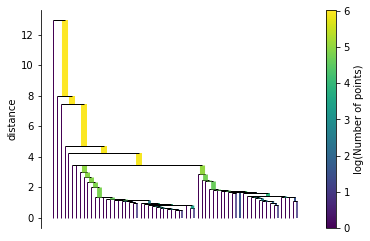

In [184]:
clusterer_avg = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, prediction_data=True,
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

cluster_labels = clusterer_avg.fit(avg_infection)

print(clusterer_avg.labels_)
print(clusterer_avg.labels_.max())
print(clusterer_avg.probabilities_)

clusterer_avg.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

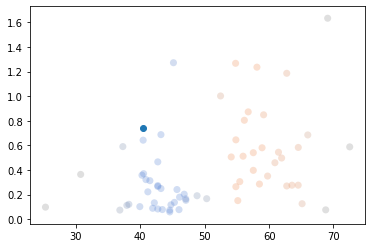

In [185]:
color_palette = sns.color_palette('muted')
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer_avg.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer_avg.probabilities_)]
plt.scatter(*avg_infection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.scatter(x=40.462921348314595,y=0.7443739991716158)

In [186]:
# Applying new point to cluster, seeing what class it lands on

test_labels, strengths = hdbscan.approximate_predict(clusterer_avg, [[40.462921348314595,0.7443739991716158]])

print(test_labels, strengths)

[0] [1.]


In [187]:
values = [int(i) for i in clusterer_avg.labels_]

fig = ff.create_choropleth(fips=correct_fips, values=values, legend_title='Cluster Labels (-1 = unclustered)', show_hover=True, colorscale = ["#8C8C8C","#4878D0","#EE8549"])
# fig.layout.template = None
fig.show()

# Cluster Analysis

1. Adequately describe the function you would like to calculate. (specify the domain and range, semantics)
    * Is this a reasonable task?
    * What are its input and output?
2. Choose parameterized functions that are easier to calculate then the original function. (e.g. choosing a neural network, and specified layers)
    * You will compose these "easier to calculate" functions in hopes of recovering an approximation of the original.
    * The proper choice of parametrized functions is extremely important. We want them to reflect properties of the function we are trying to model. This will result in less parameters and easier training.
3. Create/Choose a loss function that captures how well your model does. (e.g., mean squared error, crossentropy, etc..)
    * It helps if the loss is differentiable with respect to the parameters.
4. Given the loss and composition of parameterized functions, choose an optimizer that updates the parameters to minimize the loss.( e.g., sgd, adagrad, adam, ...)
5. Evaluate how well the model did.
    * Can we change any of model parameters to achieve better results,e.g., learning rate, number of composite functions, etc...?
    * Is the model overtrained/undertrained?

### Data

In this project, I chose to apply clustering to my dataset. I tested various feature combinations of the variance of the temperature, average temperature, and infection rate for 66 counties in the United States over 90 days. From it, I hoped to attain some sort of relationship inside each cluster given by the clustering algorithm to make sense of how temperature affects the infection rate of COVID-19. I hypothesized that the higher the temperature the lower infection rate and vice versa. Despite this effort, I do not believe there is much to be extracted from this model based on this hypothesis; though, I do think this task is reasonable in terms of workload. The difficult part was finding, sorting, and aggregating data for the infections, deaths, populations, and temperature. I used the Google BigQuery dataset, US Census API and Wunderground scraping and sanitized and organized the data.

These are the calculations involved with calculating the infection rate $\beta$, sample mean temperature $M_n$, and sample variance $V_n$ of the temperature for each county.

## Infection rate

$\displaystyle \frac{dS}{dt}=-\frac{\beta I S}{S+I+R} \implies \beta = -\frac{dS}{dt} \frac{S + I + R}{IS}$

$\displaystyle \frac{dI}{dt} = \frac{\beta I S}{S + I + R} - \gamma I$

$S(t) = $population

$I(t) = $infected

$R(t) = $dead

## Sample mean

$\displaystyle M_n = \frac{1}{n} \sum_{i = 1}^n T_i$

$T_i =$ temperature per day

## Sample Variance

$\displaystyle V_n = \frac{\sum (T_i - M_n)^2}{n - 1}$

### Modelling

In terms of clustering, the algorithm maps points to a group instead of giving function in a traditional machine learning sense. For example, if a point lands within a certain clustered area, it will return a class corresponding to that clustered area. Additionally, it does not have a loss or optimizer in a traditional sense either. Instead, we have parameters we tweak parameters such as the minimum cluster size that adjusts how many points should be in a cluster at minimum and the metric, or how we want to quantify whether a point belongs into a cluster or not. In my case, I tweaked the minimum cluster size to be five in order to have distinct, spanning clusters instead of many small ones. Also, I used the Euclidian metric to make the distances the metric for clustering.

For each attempt, I graphed the data points and how the algorithm clustered the data. I colored each point according to their cluster. Gray (-1) specifies unclustered data, while other colors (0,1,...) specifies clustered data. I also colored each county according to their cluster.

For the first attempt, I modeled the all three features (variance of temperature, average temperature, and infection rate) and clustered it. It seemed to be clustered based on the variance of the temperature. No immediate or blatant relationships that I can decipher appear. Two clusters were derived.

Furthermore, for the second attempt, I modeled just the variance of the temperature and infection rate and clustered it. This time, no apparent clustering pattern can be seen. There were three clusters.

Finally, I modeled the average temperature and infection rate. This time, it seemed to have grouped based on the temperature, as seen on the map. Two clusters were created.

To make sense of the data, I think more analysis is required to juxtapose the classes against a variety external data, such as seeing whether the counties had stay at home orders. Additionally, to improve the model, increasing the number of data points could help since I only have 66 counties currently. Also, as time continues and summer arrives, I could take into account a varied amount of temperatures. Ultimately, I do not think my hypothesis has been answered, and further analysis is needed.